In [100]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Notebook for catboost model development and testing

scores, frequency 15min: 
training on observed data only 
- 173 med objective="MultiRSME", learning_rate=0.10931167365445349, colsample_bylevel=0.09963123954233088, max_depth=15, boosting_type="Plain", bootstrap_type="MVS"
- 171 med objective="MAE", learning_rate=0.10931167365445349, colsample_bylevel=0.09963123954233088, max_depth=15, boosting_type="Plain", bootstrap_type="MVS"
- 180 med vanlig catboost, trent på time series data. 

training on both observed and estimated 


TRAINING ON HOURLY DATA 

159 - using normal catboost


168 - using catboost with objective="MAE", learning_rate=0.10931167365445349 colsample_bylevel=0.09963123954233088, max_depth=15, boosting_type="Plain", bootstrap_type="MVS"

150 - # ("cat", CatBoostRegressor(**{'objective': 'MAE', 'colsample_bylevel': 0.08393035401844894, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.6491381658313076, "random_seed":0})),
all features + FE, TRAINED ON ABC COMBINED WITH LOCATION FEATURE

152 - Catboost optimized with the removed feats from Eirik, also removing const intervals (30/2), no BC donation, before Henrik fix. Trained each model seperatly, optimized seperat also, 
params A : #[I 2023-11-06 10:05:05,399] Trial 26 finished with value: 165.8851952022578 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09930576154462276, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 26 with value: 165.8851952022578.
params B : #[I 2023-11-06 10:26:38,751] Trial 25 finished with value: 22.26772405170921 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09981161016617257, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5119008311351512}. Best is trial 25 with value: 22.26772405170921.
params C : #[I 2023-11-06 10:59:09,821] Trial 33 finished with value: 19.716058939096268 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09644126188381036, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9881316487405227}. Best is trial 33 with value: 19.716058939096268.

153 - Catboost one trained for A and one for BC combined. Optimized seperatly, used constant interval cutoff (20/3) and BC donation. 
Params A : {'objective': 'MAE', 'colsample_bylevel': 0.09930576154462276, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'random_seed':42}
Params BC : {'objective': 'MAE', 'colsample_bylevel': 0.0819245485589076, 'depth': 13, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}



## Getting data


## Training on combined observed and estimated data

In [107]:
%store -r dm 


dm = dm



In [108]:
from sklearn.model_selection import train_test_split 
import pandas as pd

X = dm.data.iloc[:, 2:]
y = dm.data.iloc[:, 1]

X_A = dm.data_A.iloc[:, 2:]
y_A = dm.data_A.iloc[:, 1]
X_B = dm.data_B.iloc[:, 2:]
y_B = dm.data_B.iloc[:, 1]
X_C = dm.data_C.iloc[:, 2:]
y_C = dm.data_C.iloc[:, 1]

X_A = dm.add_location(X_A, "A")
X_B = dm.add_location(X_B, "B")
X_C = dm.add_location(X_C, "C")

X_train_A = X_A.iloc[0:int(0.7*X_A.shape[0]):]
y_train_A = y_A.iloc[0:int(0.7*y_A.shape[0]):]
X_test_A = X_A.iloc[-int(0.3*X_A.shape[0]):] 
y_test_A = y_A.iloc[-int(0.3*y_A.shape[0]):]

#X_test_A, X_validate_A, y_test_A, y_validate_A = train_test_split(X_test_A, y_test_A, train_size=0.4, shuffle=False)

X_train_B = X_B.iloc[0:int(0.7*X_B.shape[0]):]
y_train_B = y_B.iloc[0:int(0.7*y_B.shape[0]):]
X_test_B = X_B.iloc[-int(0.3*X_B.shape[0]):] 
y_test_B = y_B.iloc[-int(0.3*y_B.shape[0]):] 

#X_test_B, X_validate_B, y_test_B, y_validate_B = train_test_split(X_test_B, y_test_B, train_size=0.4, shuffle=False)

X_train_C = X_C.iloc[0:int(0.7*X_C.shape[0]):]
y_train_C = y_C.iloc[0:int(0.7*y_C.shape[0]):]
X_test_C = X_C.iloc[-int(0.3*X_C.shape[0]):] 
y_test_C = y_C.iloc[-int(0.3*y_C.shape[0]):] 

#X_test_C, X_validate_C, y_test_C, y_validate_C = train_test_split(X_test_C, y_test_C, train_size=0.4, shuffle=False)

X_train = pd.concat([X_train_A, X_train_B, X_train_C], ignore_index=True)
#X_validate = pd.concat([X_validate_A, X_validate_B, X_validate_C], ignore_index=True)
X_test = pd.concat([X_test_A, X_test_B, X_test_C], ignore_index=True)

y_train = pd.concat([y_train_A, y_train_B, y_train_C], ignore_index=True)
#y_validate = pd.concat([y_validate_A, y_validate_B, y_validate_C], ignore_index=True)
y_test = pd.concat([y_test_A, y_test_B, y_test_C], ignore_index=True)

X_submission = dm.X_test_estimated[dm.X_test_estimated.columns.intersection(X.columns)]

X_submission_A = dm.X_test_estimated_a[dm.X_test_estimated_a.columns.intersection(X_A.columns)]
X_submission_B = dm.X_test_estimated_b[dm.X_test_estimated_b.columns.intersection(X_B.columns)]
X_submission_C = dm.X_test_estimated_c[dm.X_test_estimated_c.columns.intersection(X_C.columns)]

X_submission.isna().sum()


is_day:idx                            0
is_in_shadow:idx                      0
clear_sky_energy_1h:J                 0
diffuse_rad_1h:J                      0
direct_rad_1h:J                       0
fresh_snow_12h:cm                     0
fresh_snow_24h:cm                     0
precip_5min:mm                        0
rain_water:kgm2                       0
snow_water:kgm2                       0
super_cooled_liquid_water:kgm2        0
absolute_humidity_2m:gm3              0
air_density_2m:kgm3                   0
clear_sky_rad:W                       0
dew_point_2m:K                        0
diffuse_rad:W                         0
direct_rad:W                          0
effective_cloud_cover:p               0
msl_pressure:hPa                      0
pressure_100m:hPa                     0
pressure_50m:hPa                      0
relative_humidity_1000hPa:p           0
sfc_pressure:hPa                      0
sun_azimuth:d                         0
sun_elevation:d                       0


## Using timeseries split to split our data 

In [6]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=10,
    gap=15,
    max_train_size=7000,
    test_size=1000,
)

all_splits = list(ts_cv.split(X_train, y_train))




## Kfolds split 

In [50]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True)

all_splits = list(kf.split(X_train_A, y_train_A))



## Defining models

In [113]:
from catboost import CatBoostRegressor


# catModel_A = CatBoostRegressor(objective="MAE", random_seed=42, boosting_type="Plain", depth=7, l2_leaf_reg=2, iterations=2000)
# catModel_B = CatBoostRegressor(objective="MAE", random_seed=42, boosting_type="Plain", depth=7, l2_leaf_reg=2, iterations=2000)
# catModel_C = CatBoostRegressor(objective="MAE", random_seed=42, boosting_type="Plain", depth=7, l2_leaf_reg=2, iterations=2000)

catModel_A = CatBoostRegressor(objective="MAE", random_seed=42)
catModel_B = CatBoostRegressor(objective="MAE", random_seed=42)
catModel_C = CatBoostRegressor(objective="MAE", random_seed=42)


# catModel_BC = CatBoostRegressor(**{'objective': 'MAE', 'colsample_bylevel': 0.0819245485589076, 'depth': 13, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'})


## Optimizing hyperparams

### Tuning model for set A

In [244]:
#[I 2023-11-05 16:59:05,004] Trial 5 finished with value: 116.02466557883027 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.08555204354589313, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'iterations': 1190, 'bagging_temperature': 5.833922769277539}. Best is trial 5 with value: 116.02466557883027.

# these params scored 150 
# ("cat", CatBoostRegressor(**{'objective': 'MAE', 'colsample_bylevel': 0.08393035401844894, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.6491381658313076, "random_seed":0})),

# [I 2023-11-05 22:37:34,489] Trial 20 finished with value: 161.77335724365003 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09961018030513795, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.755437017114945}. Best is trial 20 with value: 161.77335724365003.

## EIRIK DELETED FEATS 

## with validation split 
#[I 2023-11-06 10:05:05,399] Trial 26 finished with value: 165.8851952022578 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09930576154462276, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 26 with value: 165.8851952022578.
#[I 2023-11-06 09:59:39,114] Trial 13 finished with value: 165.99023283160864 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09894236237775247, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 165.99023283160864.

## EIRIK DELETED FEATS + LAG FEATS - SUM RAD
#[I 2023-11-06 14:18:01,581] Trial 26 finished with value: 165.43080979284372 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09922457244655024, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 26 with value: 165.43080979284372.
#[I 2023-11-06 14:14:27,365] Trial 22 finished with value: 166.69347928436912 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.07845778545183921, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 22 with value: 166.69347928436912.


## ALL FEATS + FE, NO LAG FEATS, BC DONATION AND REMOVING CONST INTERVALS (12/3)
#[I 2023-11-06 18:47:26,359] Trial 12 finished with value: 169.74903878583473 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.07321108308140112, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9947382455838534}. Best is trial 12 with value: 169.74903878583473.
#[I 2023-11-06 18:45:18,746] Trial 11 finished with value: 171.92396530956395 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.068755243871172, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9942926270291108}. Best is trial 11 with value: 171.92396530956395.
#[I 2023-11-06 18:51:54,938] Trial 15 finished with value: 170.281074439894 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.08074887258271649, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.10570616951506}. Best is trial 12 with value: 169.74903878583473.


import optuna
import numpy as np
from sklearn.metrics import mean_absolute_error
from optuna.samplers import TPESampler

def objective(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["MAE"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 16),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        # "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "has_time":True, 
        
        
        #"iterations": trial.suggest_int("iterations", 10, 1500),
        
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cb = CatBoostRegressor(**param)

    cb.fit(X_train_A, y_train_A, eval_set=[(X_validate_A, y_validate_A)], verbose=0, early_stopping_rounds=100, use_best_model=True)

    preds = cb.predict(X_test_A)
    pred_labels = np.rint(preds)
    accuracy = mean_absolute_error(y_test_A, pred_labels)
    return accuracy

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=None)

[I 2023-11-11 00:01:00,505] A new study created in memory with name: no-name-9747080d-8e99-4732-94f2-2edbd0ac9950
[I 2023-11-11 00:01:02,348] Trial 0 finished with value: 298.49551909892267 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.04171037768530977, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 298.49551909892267.
[I 2023-11-11 00:01:05,879] Trial 1 finished with value: 275.56932908912836 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.08481514512364302, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.0194323923289605}. Best is trial 1 with value: 275.56932908912836.
[I 2023-11-11 00:01:07,287] Trial 2 finished with value: 318.7553036238981 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.01605920544239829, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 275.56932908912836.
[I 2023-11-11 00:01:08,525] Trial 3 fi

KeyboardInterrupt: 

In [6]:
# rundt 213 på lokal test boosting_type="Plain", depth=10, learning_rate=0.05, l2_leaf_reg=3, iterations=5000, rsm=0.15


from sklearn.model_selection import RandomizedSearchCV
import sys
from catboost import CatBoostRegressor
model = CatBoostRegressor(objective="RMSE", silent=True)

grid = {
        'depth': [6, 10, 12],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'iterations': [100, 500, 1000, 5000, 10000],
        'boosting_type': ['Ordered', 'Plain'],
        "colsample_bylevel": [0.01, 0.05, 0.1, 0.15, 0.17, 0.2, 0.25]

        }

randomized_search_result = model.randomized_search(grid,
                                                   X=X_A,
                                                   y=y_A,
                                                   plot="True",
                                                   shuffle=False,
                                                   verbose=2,
                                                   
                                                   )



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 379.910167
bestIteration = 4999

0:	loss: 379.9101670	best: 379.9101670 (0)	total: 19s	remaining: 2m 50s

bestTest = 365.9478927
bestIteration = 488



KeyboardInterrupt: 

In [59]:
randomized_search_result["params"]

NameError: name 'randomized_search_result' is not defined

### Tuning model for set B


In [50]:
# [I 2023-11-05 22:43:53,232] Trial 2 finished with value: 25.414357904741664 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.06927535477671466, 'depth': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.10515029581800527}. Best is trial 2 with value: 25.414357904741664.

# EIRIK DELETED FEATS 

## Proper validation: 
#[I 2023-11-06 10:26:38,751] Trial 25 finished with value: 22.26772405170921 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09981161016617257, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5119008311351512}. Best is trial 25 with value: 22.26772405170921.
#[I 2023-11-06 10:35:56,976] Trial 33 finished with value: 22.62602913068846 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.0953035979637657, 'depth': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4988564621460619}. Best is trial 25 with value: 22.26772405170921.


## EIRIK DELETED FEATS + LAG FEATS - SUM RAD


import optuna
import numpy as np
from sklearn.metrics import mean_absolute_error
from optuna.samplers import TPESampler

def objective(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["MAE"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 16),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        #"iterations": trial.suggest_int("iterations", 10, 1500),
        "random_seed": 0,
        
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cb = CatBoostRegressor(**param)

    cb.fit(X_B_train, y_B_train, eval_set=[(X_B_validate, y_B_validate)], verbose=0, early_stopping_rounds=100)

    preds = cb.predict(X_B_test)
    pred_labels = np.rint(preds)
    accuracy = mean_absolute_error(y_B_test, pred_labels)
    return accuracy

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=100, timeout=None)

[I 2023-11-06 15:13:08,258] A new study created in memory with name: no-name-7668151d-b69e-4574-b029-b51f4afb7b81


[W 2023-11-06 15:13:13,754] Trial 0 failed with parameters: {'objective': 'MAE', 'colsample_bylevel': 0.04370861069626263, 'depth': 16, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.661761457749352} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/Users/jonasolsen/Documents/Skole/IIkt/5_semester/TDT4173 - Maskinlæring/ve/group_project/.venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/m51x_wn949x1s34wqwqf6hkr0000gn/T/ipykernel_2205/3937913936.py", line 40, in objective
    cb.fit(X_B_train, y_B_train, eval_set=[(X_B_validate, y_B_validate)], verbose=0, early_stopping_rounds=100)
  File "/Users/jonasolsen/Documents/Skole/IIkt/5_semester/TDT4173 - Maskinlæring/ve/group_project/.venv/lib/python3.9/site-packages/catboost/core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding

KeyboardInterrupt: 

### Tuning model for set C

In [20]:
# [I 2023-11-05 23:01:43,697] Trial 12 finished with value: 22.37118032357372 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.06718168961955846, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3200703207067206}. Best is trial 12 with value: 22.37118032357372.

# EIRIK DELETED FEATS 

#proper validatioon 
#[I 2023-11-06 10:45:49,758] Trial 28 finished with value: 20.537135559921417 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09350538147690629, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.842124245488673}. Best is trial 28 with value: 20.537135559921417.
#[I 2023-11-06 10:43:30,999] Trial 22 finished with value: 20.997127701375245 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.08944284279926223, 'depth': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.930004930966931}. Best is trial 22 with value: 20.997127701375245.
#[I 2023-11-06 10:59:09,821] Trial 33 finished with value: 19.716058939096268 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09644126188381036, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9881316487405227}. Best is trial 33 with value: 19.716058939096268.
#[I 2023-11-06 10:57:44,252] Trial 31 finished with value: 19.721968565815324 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09517386033361759, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9934480446809176}. Best is trial 31 with value: 19.721968565815324.
#[I 2023-11-06 10:57:04,178] Trial 30 finished with value: 20.012184675834973 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09999890845914448, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9877850694321213}. Best is trial 30 with value: 20.012184675834973.


import optuna
import numpy as np
from sklearn.metrics import mean_absolute_error

def objective(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["MAE"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 16),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        #"iterations": trial.suggest_int("iterations", 10, 1500),
        
        
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cb = CatBoostRegressor(**param)

    cb.fit(X_C_train, y_C_train, eval_set=[(X_C_validate, y_C_validate)], verbose=0, early_stopping_rounds=100)

    preds = cb.predict(X_C_test)
    pred_labels = np.rint(preds)
    accuracy = mean_absolute_error(y_C_test, pred_labels)
    return accuracy

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=None)

[I 2023-11-06 10:37:33,208] A new study created in memory with name: no-name-b3f0cea1-f607-4040-bb49-df2c97709679
[I 2023-11-06 10:37:37,435] Trial 0 finished with value: 23.75532023575639 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09632611922330145, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5708654585946807}. Best is trial 0 with value: 23.75532023575639.
[I 2023-11-06 10:37:38,547] Trial 1 finished with value: 26.297229862475447 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.038924284700302805, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 23.75532023575639.
[I 2023-11-06 10:37:39,773] Trial 2 finished with value: 25.565819253438114 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.07027593983826509, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 23.75532023575639.
[I 2023-11-06 10:37:40,684] Trial 3 finished wi

KeyboardInterrupt: 

### Tuning BC Combined

In [97]:
## ALL FEATS + FE, NO LAG FEATS, BC DONATION AND REMOVING CONST INTERVALS (20/3)
#[I 2023-11-06 18:55:46,070] Trial 0 finished with value: 18.485309556165106 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09003451962386975, 'depth': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1912152898699087}. Best is trial 0 with value: 18.485309556165106.
#[I 2023-11-06 19:16:42,672] Trial 3 finished with value: 17.818673155834432 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.0819245485589076, 'depth': 13, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 3 with value: 17.818673155834432.
#[I 2023-11-06 19:16:46,131] Trial 4 finished with value: 20.735737001810563 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.03948636560626, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 3 with value: 17.818673155834432.


import optuna
import numpy as np
from sklearn.metrics import mean_absolute_error

def objective(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["MAE"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 16),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        #"iterations": trial.suggest_int("iterations", 10, 1500),
        
        
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cb = CatBoostRegressor(**param)

    cb.fit(X_BC_train, y_BC_train, eval_set=[(X_BC_validate, y_BC_validate)], verbose=0, early_stopping_rounds=100)

    preds = cb.predict(X_BC_test)
    pred_labels = np.rint(preds)
    accuracy = mean_absolute_error(y_BC_test, pred_labels)
    return accuracy

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=None)

[I 2023-11-06 18:55:30,485] A new study created in memory with name: no-name-b6c6ba4e-08ef-4d93-b73d-39f578771625
[I 2023-11-06 18:55:46,070] Trial 0 finished with value: 18.485309556165106 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09003451962386975, 'depth': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1912152898699087}. Best is trial 0 with value: 18.485309556165106.
[I 2023-11-06 18:55:47,982] Trial 1 finished with value: 21.58766943887857 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.015941506826069554, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 18.485309556165106.
[I 2023-11-06 18:55:49,418] Trial 2 finished with value: 23.460974912584852 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.06720921460494261, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.21265898043362383}. Best is trial 0 with value: 18.485309556165106.
[I 2

KeyboardInterrupt: 

### Tuning on whole set (A B C combined)

In [48]:

#[I 2023-11-06 09:21:40,140] Trial 7 finished with value: 93.57082723599223 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.07021145849459196, 'depth': 15, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 93.57082723599223.
#[I 2023-11-06 09:18:27,362] Trial 6 finished with value: 104.18112832124598 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.07343258702862919, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 4 with value: 99.6739211164172.
#[I 2023-11-06 09:18:19,613] Trial 4 finished with value: 99.6739211164172 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.05987187094961611, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8627037092982467}. Best is trial 4 with value: 99.6739211164172.

## PROPER VALIDATION 
# [I 2023-11-06 09:34:06,886] Trial 11 finished with value: 94.84395099535925 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.06788514856337621, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3089743943699958}. Best is trial 1 with value: 91.96302490499082.
# [I 2023-11-06 09:34:12,735] Trial 12 finished with value: 90.99607534299506 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.06879424422985089, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1356440119309477}. Best is trial 12 with value: 90.99607534299506.
# [I 2023-11-06 09:34:19,982] Trial 13 finished with value: 90.15040743548006 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.06831027771726123, 'depth': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1059090481359448}. Best is trial 13 with value: 90.15040743548006.
# [I 2023-11-06 09:34:49,324] Trial 14 finished with value: 85.26022828486518 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.0764308167143037, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.11317034357345056}. Best is trial 14 with value: 85.26022828486518.
# [I 2023-11-06 09:36:04,025] Trial 15 finished with value: 81.02983953897846 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.08556050159260666, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.10142252384867761}. Best is trial 15 with value: 81.02983953897846.
# USED THIS FOR SUB CATBOOST_13_SINGLE.CSV [I 2023-11-06 09:37:51,323] Trial 16 finished with value: 78.62797533658944 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09994261947773965, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3517029793822252}. Best is trial 16 with value: 78.62797533658944.
# [I 2023-11-06 09:39:42,441] Trial 17 finished with value: 78.80238554236068 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09990666905586555, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.39528335187495645}. Best is trial 16 with value: 78.62797533658944.
# [I 2023-11-06 09:40:12,070] Trial 18 finished with value: 82.74867457461298 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09991105102282588, 'depth': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.44205347186589705}. Best is trial 16 with value: 78.62797533658944.
# [I 2023-11-06 09:40:19,573] Trial 19 finished with value: 86.11596511811832 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.0993444194374076, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4163694923198905}. Best is trial 16 with value: 78.62797533658944.
# [I 2023-11-06 09:40:24,566] Trial 20 finished with value: 95.64983586751998 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.08625070811470684, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5965498517007939}. Best is trial 16 with value: 78.62797533658944.
# [I 2023-11-06 09:41:48,783] Trial 21 finished with value: 80.34018050497714 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.08828388798152162, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.29136732663727677}. Best is trial 16 with value: 78.62797533658944.
# [I 2023-11-06 09:42:34,832] Trial 22 finished with value: 81.1204320957182 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.0918243857157667, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.35999148599335806}. Best is trial 16 with value: 78.62797533658944.
# [I 2023-11-06 09:44:15,154] Trial 23 finished with value: 79.2280725426542 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09386351381323012, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.29478409296370756}. Best is trial 16 with value: 78.62797533658944.
# [I 2023-11-06 09:44:42,818] Trial 24 finished with value: 81.19963365555299 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09997495410247971, 'depth': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4802613284856091}. Best is trial 16 with value: 78.62797533658944.
# [I 2023-11-06 09:45:01,658] Trial 25 finished with value: 85.19633893372021 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.07924963444764457, 'depth': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 78.62797533658944.

## EIRIK DELETED FEATS + LAG FEATS - SUM RAD
# USED THIS FOR SUB CATBOOST_14_SINGLE.CSV [I 2023-11-06 16:04:47,625] Trial 41 finished with value: 83.411573402198 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09618156200475811, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.21387042043411192}. Best is trial 41 with value: 83.411573402198.
# [I 2023-11-06 15:44:49,977] Trial 30 finished with value: 83.51429978562304 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09926156367081514, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.271617400472478}. Best is trial 30 with value: 83.51429978562304.
# [I 2023-11-06 15:29:27,387] Trial 24 finished with value: 84.02207338155672 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09850904799670648, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2994539222163096}. Best is trial 24 with value: 84.02207338155672.

## ALL FEATS + FE, NO LAG FEATS, BC DONATION AND REMOVING CONST INTERVALS (20/3)
#[I 2023-11-06 21:22:41,277] Trial 18 finished with value: 19.06275303157211 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.08101231188824651, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1203886158980404}. Best is trial 18 with value: 19.06275303157211.
#[I 2023-11-06 21:25:20,073] Trial 21 finished with value: 19.02159924912772 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.07731293544992492, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3756198315698245}. Best is trial 21 with value: 19.02159924912772.
#[I 2023-11-06 21:30:31,243] Trial 25 finished with value: 18.844086323227387 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09981161016617257, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5119008311351512}. Best is trial 25 with value: 18.844086323227387.

## AFTER LOG CLEANUP, ALL FEATS + FE, -23 LAG FEAT, CROPPED BC DONATION (4000 FROM START OF C) REMOVING CONST INTERVALS (12/3)
#[I 2023-11-08 15:07:35,959] Trial 12 finished with value: 132.51621218556318 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.06793414629614411, 'depth': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 12 with value: 132.51621218556318.


## IDK NEW - SCORED 149.7 WITH 50/50 PREV BEST SUB - REMOVED CONST (24, NONE ) - NO BC DONATION - NEW RESAMPLING - NOTE: WE AVERAGED THIS SUB 50/50 WITH OUR PREVIOUS BEST PRED
#[I 2023-11-09 17:30:48,787] Trial 13 finished with value: 94.5142676297783 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.08274297094205027, 'depth': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'iterations': 4134, 'l2_leaf_reg': 2, 'subsample': 0.9964148785726921}. Best is trial 13 with value: 94.5142676297783.
#[I 2023-11-09 17:33:44,019] Trial 23 finished with value: 93.24153393978231 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09976223131038761, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'iterations': 9439, 'l2_leaf_reg': 4, 'subsample': 0.7352510777227594}. Best is trial 23 with value: 93.24153393978231.
#[I 2023-11-09 17:37:12,777] Trial 31 finished with value: 93.7266074724392 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09541554056361602, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'iterations': 9766, 'l2_leaf_reg': 4, 'subsample': 0.7378327325323509}. Best is trial 23 with value: 93.24153393978231.

## REMOVED CONST (24, 3) - NO BC DONATION - NEW RESAMPLING - ADDED FEATURE "BAD_CLOUD_MEASUREMENT" 
#[I 2023-11-09 18:40:41,534] Trial 24 finished with value: 124.00875360304717 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.08622997524989685, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'iterations': 8743, 'l2_leaf_reg': 2, 'subsample': 0.8655554193771717}. Best is trial 24 with value: 124.00875360304717.



import optuna
import numpy as np
from sklearn.metrics import mean_absolute_error
from optuna.samplers import TPESampler
from catboost import CatBoostRegressor

def objective(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["MAE"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 16),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "iterations": trial.suggest_int("iterations", 10, 10000),
        "random_seed": 0,
        'l2_leaf_reg':trial.suggest_int("l2_leaf_reg", 1, 9)
        
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cb = CatBoostRegressor(**param)

    cb.fit(X_train, y_train, eval_set=[(X_validate, y_validate)], verbose=0, early_stopping_rounds=100)

    preds = cb.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = mean_absolute_error(y_test, pred_labels)
    return accuracy

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=100, timeout=None)

[I 2023-11-09 18:30:11,850] A new study created in memory with name: no-name-528048b7-f9e3-44e0-9b2e-12f4e96ef84a


[I 2023-11-09 18:33:24,734] Trial 0 finished with value: 151.41928325097797 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.04370861069626263, 'depth': 16, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'iterations': 8663, 'l2_leaf_reg': 6, 'bagging_temperature': 7.080725777960454}. Best is trial 0 with value: 151.41928325097797.
[I 2023-11-09 18:33:54,054] Trial 1 finished with value: 252.892949094091 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.011852604486622221, 'depth': 16, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'iterations': 5252, 'l2_leaf_reg': 4}. Best is trial 0 with value: 151.41928325097797.
[I 2023-11-09 18:34:00,548] Trial 2 finished with value: 142.34859764257774 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.036210622617823776, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'iterations': 2004, 'l2_leaf_reg': 5}. Best is trial 2 with value: 142.34859764257774.
[I 2023-11-09 18:34:22,553] Tri

KeyboardInterrupt: 

## LGBM TUNING (Henrik) combined model

In [13]:
# [I 2023-11-09 18:55:30,132] Trial 87 finished with value: 120.77856277203877 and parameters: {'learning_rate': 0.013032365661988657, 'num_leaves': 53, 'subsample': 0.9986358809270887, 'colsample_bytree': 0.9360947994179326, 'min_data_in_leaf': 61}. Best is trial 87 with value: 120.77856277203877.
import lightgbm as lgb
from optuna.samplers import TPESampler
import optuna
import numpy as np
from sklearn.metrics import mean_absolute_error

# X_train.columns = X_train.columns.str.replace(':', '_')
# y_train.columns = y_train.columns.str.replace(':', '_')
# X_test.columns = X_test.columns.str.replace(':', '_')
# y_test.columns = y_test.columns.str.replace(':', '_')


def objective_lgb(trial):
    params = {
        "objective": "regression",
        "metric": "mae",
        "n_estimators": 10000,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    return mae


sampler = TPESampler(seed=1001)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective_lgb, n_trials=100, timeout=None)

[I 2023-11-09 19:23:23,452] A new study created in memory with name: no-name-492cb0f8-96cb-4d5c-8f6e-a25207d8144c
[I 2023-11-09 19:24:38,595] Trial 0 finished with value: 143.0883202436783 and parameters: {'learning_rate': 0.004096984860316588, 'num_leaves': 273, 'subsample': 0.23625705999359387, 'colsample_bytree': 0.4589954027386952, 'min_data_in_leaf': 3}. Best is trial 0 with value: 143.0883202436783.
[I 2023-11-09 19:25:42,590] Trial 1 finished with value: 129.44651681383408 and parameters: {'learning_rate': 0.002463563892436499, 'num_leaves': 362, 'subsample': 0.2620799183784517, 'colsample_bytree': 0.6328457629117186, 'min_data_in_leaf': 59}. Best is trial 1 with value: 129.44651681383408.
[I 2023-11-09 19:26:02,667] Trial 2 finished with value: 128.91552233136377 and parameters: {'learning_rate': 0.050948963956942164, 'num_leaves': 44, 'subsample': 0.5137657156165406, 'colsample_bytree': 0.9247848484785476, 'min_data_in_leaf': 11}. Best is trial 2 with value: 128.91552233136377

KeyboardInterrupt: 

## training on the time series split 

In [10]:
## WORSE THAN WHOLE DATA 

from sklearn.metrics import mean_absolute_error
import pandas as pd

for train, test in (all_splits): 

    catModel.fit(X_train.iloc[train], y_train.iloc[train], silent=True, use_best_model=True, eval_set=(X_train.iloc[test], y_train.iloc[test]))

    preds_A = pd.DataFrame(catModel.predict(X_test))
    actual = y_test

    # preds_A = dm.scaling(preds_A, "A")
    # actual = dm.scaling(actual, "A") 

    print("CURRENT SCORING A ----->   ", mean_absolute_error(preds_A, actual))





NameError: name 'all_splits' is not defined

## training on Kfolds

In [52]:
from sklearn.metrics import mean_absolute_error
import pandas as pd


catModel_A = catModel_A.fit(X_train_A.iloc[all_splits[0][0]], y_train_A.iloc[all_splits[0][0]], silent=True, use_best_model=True, eval_set=(X_train_A.iloc[all_splits[0][1]], y_train_A.iloc[all_splits[0][1]]))


for i, (train, test) in enumerate(all_splits): 

    catModel_A.fit(X_train_A.iloc[train], y_train_A.iloc[train], silent=True, use_best_model=True, eval_set=(X_train_A.iloc[test], y_train_A.iloc[test]), init_model=catModel_A)

    preds_A = pd.DataFrame(catModel_A.predict(X_test_A))
    actual = y_test_A

    print("CURRENT SCORING A ----->   ", mean_absolute_error(preds_A, actual))




CURRENT SCORING A ----->    191.40830077453657
CURRENT SCORING A ----->    191.40434244313067
CURRENT SCORING A ----->    191.40621949191453


KeyboardInterrupt: 

## training on the normally split data 

In [114]:

catModel_A.fit(X_train_A, y_train_A, silent=True)
catModel_B.fit(X_train_B, y_train_B, silent=True)
catModel_C.fit(X_train_C, y_train_C, silent=True)


[autoreload of sklearn.utils._param_validation failed: Traceback (most recent call last):
  File "/Users/jonasolsen/Documents/Skole/IIkt/5_semester/TDT4173 - Maskinlæring/ve/group_project/.venv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/jonasolsen/Documents/Skole/IIkt/5_semester/TDT4173 - Maskinlæring/ve/group_project/.venv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/jonasolsen/Documents/Skole/IIkt/5_semester/TDT4173 - Maskinlæring/ve/group_project/.venv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/jonasolsen/Documents/Skole/IIkt/5_semester/TDT4173 - Maskinlæring/ve/group_project/.venv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
  Fi

<Axes: >

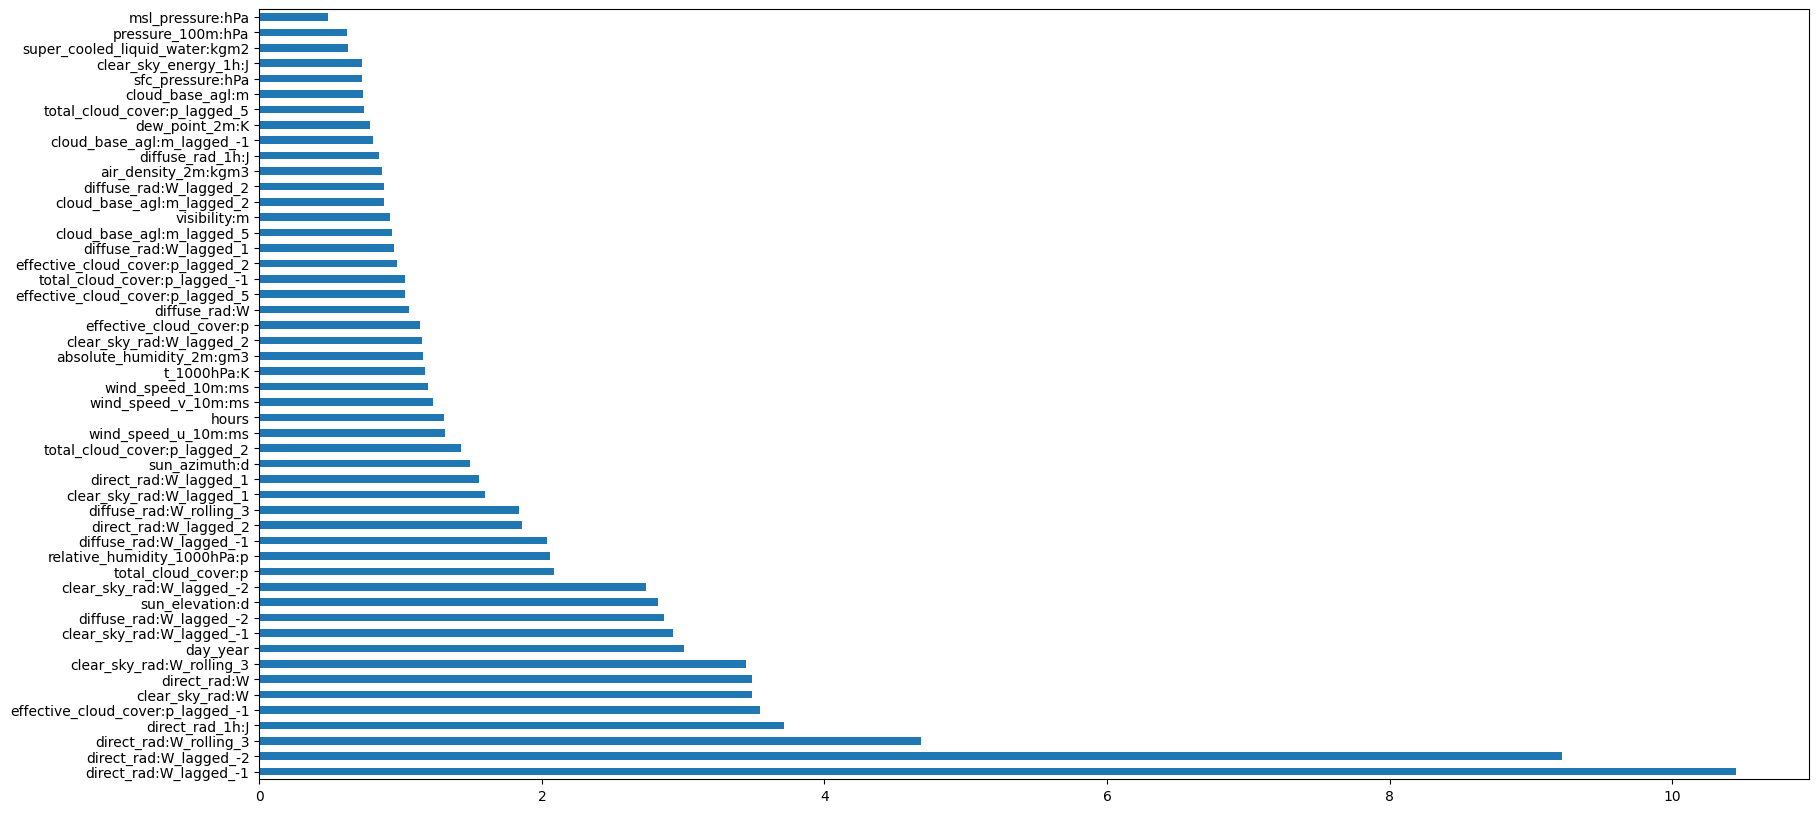

In [115]:
import pandas as pd
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(20, 10))

(pd.Series(catModel_A.feature_importances_, index=X_A.columns)
   .nlargest(50)
   .plot(kind='barh')) 

In [116]:
import pandas as pd 
from sklearn.metrics import mean_absolute_error

preds_A = pd.DataFrame(catModel_A.predict(X_test_A))
actual = y_test_A

preds_A[preds_A<0] = 0

print("CURRENT SCORING A ----->   ", mean_absolute_error(actual, preds_A))

preds_B = pd.DataFrame(catModel_B.predict(X_test_B))
actual = y_test_B

preds_B[preds_B<0] = 0

print("CURRENT SCORING B ----->   ", mean_absolute_error(actual, preds_B))

preds_C = pd.DataFrame(catModel_C.predict(X_test_C))
actual = y_test_C

preds_C[preds_C<0] = 0

print("CURRENT SCORING C ----->   ", mean_absolute_error(actual, preds_C))



CURRENT SCORING A ----->    188.40111060046488
CURRENT SCORING B ----->    18.643395194879755
CURRENT SCORING C ----->    18.260524068209325


In [71]:
## Specify the model to be used
pred_A = pd.DataFrame(catModel_A.predict(X_submission_A))
pred_B = pd.DataFrame(catModel_B.predict(X_submission_B))
pred_C = pd.DataFrame(catModel_C.predict(X_submission_C))
 
df = pd.concat([pred_A, pred_B, pred_C], ignore_index=True)
#df = pred

# df["prediction"] = pred_A


df[df<0] = 0

# NAME THE FILE 
df.to_csv("catboost_101_sep.csv")

df

,0
0,0.120743
1,71.304619
2,306.505328
3,1045.769129
4,1834.057933
...,...
2143,131.938807
2144,80.382018
2145,35.870071
2146,8.488175


<Axes: >

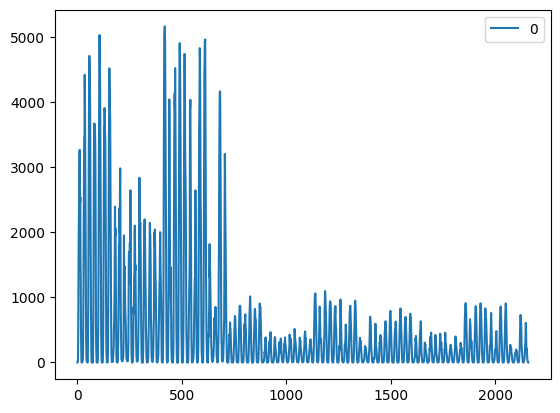

In [70]:
df.plot()